## Import libarary yang dibutuhkn

In [ ]:
!pip install Sastrawi
!pip install tensorflow
!pip install swifter
!pip install transformers
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=09f3fa335bc1b295b768d6a6cb2ab2345c5883e5e53e80bfae18fcb2afc8ea32
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import seaborn as sns
from sklearn.svm import SVC
import swifter
from tqdm import tqdm
from joblib import Parallel, delayed
from textblob import TextBlob
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Memuat Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Pastikan path sesuai dengan lokasi file di Google Drive
df = pd.read_csv('/content/drive/MyDrive/Dataset hasil scraping dengan ulasan_aplikasi_twitter.csv')



Mounted at /content/drive


# Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,userName,Rating,Review,Tanggal
0,Pengguna Google,2,"Banyak bug, jadi lemot (foto atau video sering...",2025-03-11 15:06:40
1,Pengguna Google,1,"Saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48
2,Pengguna Google,1,"semenjak jadi X malah lemot, minta update seri...",2025-02-04 22:06:28
3,Pengguna Google,4,Kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01
4,Pengguna Google,5,"Untuk pihak X, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11111 entries, 0 to 11110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  11111 non-null  object
 1   Rating    11111 non-null  int64 
 2   Review    11111 non-null  object
 3   Tanggal   11111 non-null  object
dtypes: int64(1), object(3)
memory usage: 347.3+ KB


dari dataframe diatas terdapat 11110 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [ ]:
df['Rating'].value_counts()
df['userName'].nunique()

1

 Melihat jumlah kemunculan tiap nilai di kolom Rating

In [ ]:
df.shape

(11111, 4)

In [ ]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(11110)

In [ ]:
df.describe(include='all')

,userName,Rating,Review,Tanggal
count,11111,11111.000000,11111,11111
unique,1,NaN,11101,11107
top,Pengguna Google,NaN,Sangat membantu,2025-03-11 10:43:31
freq,11111,NaN,3,2
mean,NaN,1.988480,NaN,NaN
std,NaN,1.433322,NaN,NaN
min,NaN,1.000000,NaN,NaN
25%,NaN,1.000000,NaN,NaN
50%,NaN,1.000000,NaN,NaN
75%,NaN,3.000000,NaN,NaN


1. userName
Jumlah total: 11.111

Unik: 1

Nilai paling umum: "Pengguna Google" (muncul di semua baris)

Insight:

Semua nama pengguna disamarkan.

Kolom userName tidak informatif untuk analisis, bisa diabaikan atau dibuang.

2. Rating
Tipe data: Numerik

Statistik:

Rata-rata (mean): 1.99

Standar deviasi: 1.43

Minimum: 1

Kuartil 25%: 1

Median (50%): 1

Kuartil 75%: 3

Maksimum: 5

Insight:

Distribusi rating berat ke arah negatif.

Median = 1 → lebih dari setengah user memberi bintang 1.

Hanya sebagian kecil yang memberi bintang 4–5.

3. Review
Jumlah total review: 11.111

Jumlah unik: 11.101

Review paling sering muncul: "Sangat membantu" (muncul 3 kali)

Insight:

Hampir semua review berbeda → sangat beragam.

Duplikasi sangat kecil (hanya 10 duplikat dari 11.111 data), bisa diabaikan atau dibersihkan jika perlu.

4. Tanggal
Jumlah tanggal unik: 11.107

Tanggal paling sering muncul: 2025-03-11 10:43:31 (muncul 2 kali)

Insight:

Data dikumpulkan dalam waktu yang cukup variatif.

Distribusi waktu cukup baik, tidak terfokus di satu hari.

 Kesimpulan EDA (Dataset 11.111 Review):
Sentimen pengguna cenderung negatif, mayoritas rating bintang 1.

Review sangat beragam dan organik.

Data waktu dan review cukup menyebar → bagus untuk analisis lanjutan seperti time-series atau tren.

Kolom userName bisa diabaikan karena tidak memberikan informasi tambahan.



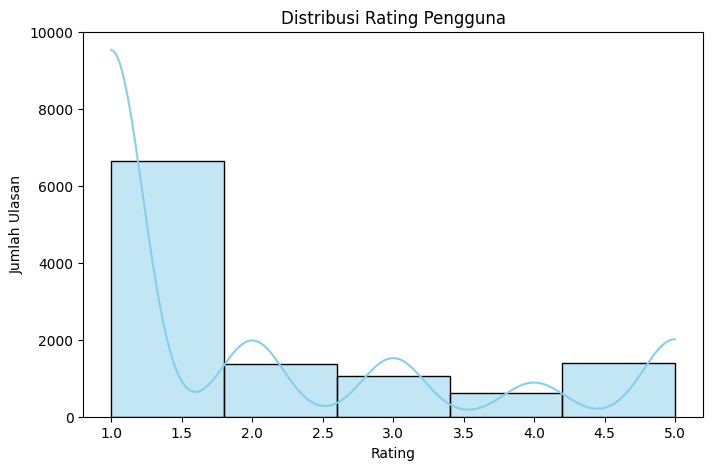

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

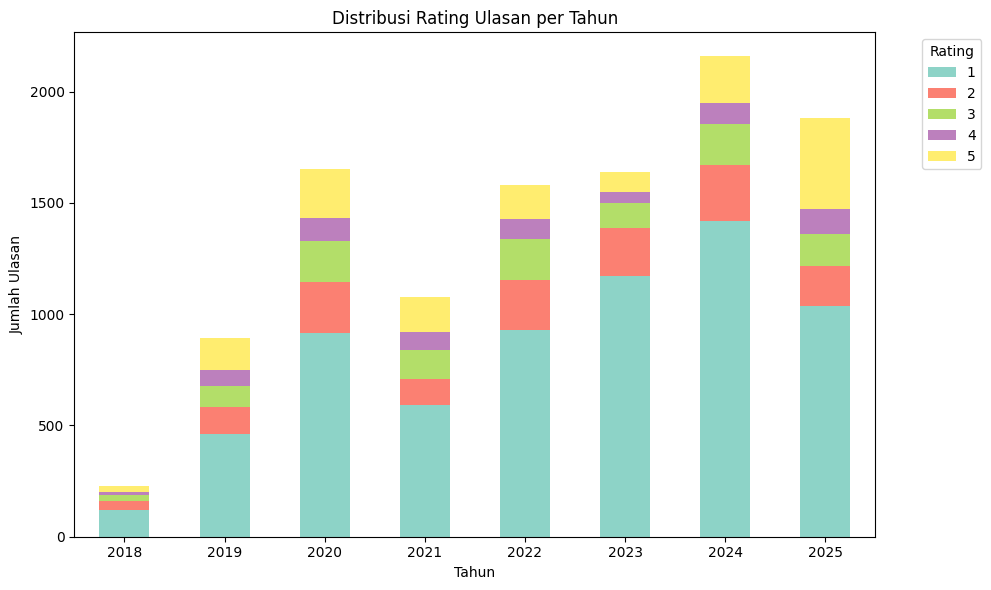

In [ ]:
# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

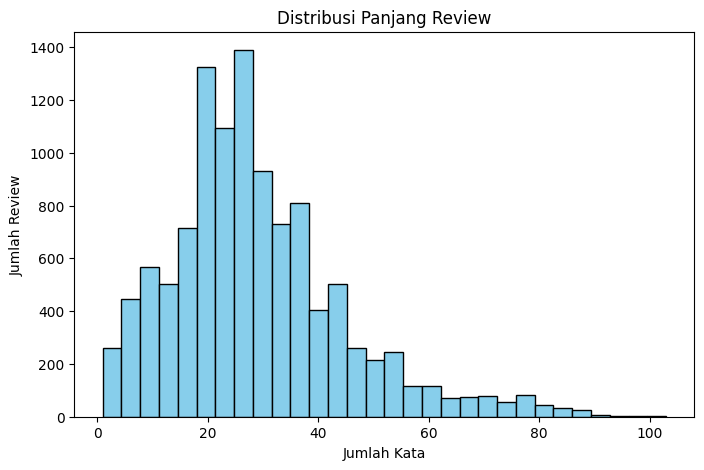

In [ ]:
# --- EDA: Distribusi Panjang Teks ---
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()


dari hasil visualisasi panjang pesan review user yang paling banayak ada di 25 untuk panjang kata 60-100 hanya sedikit

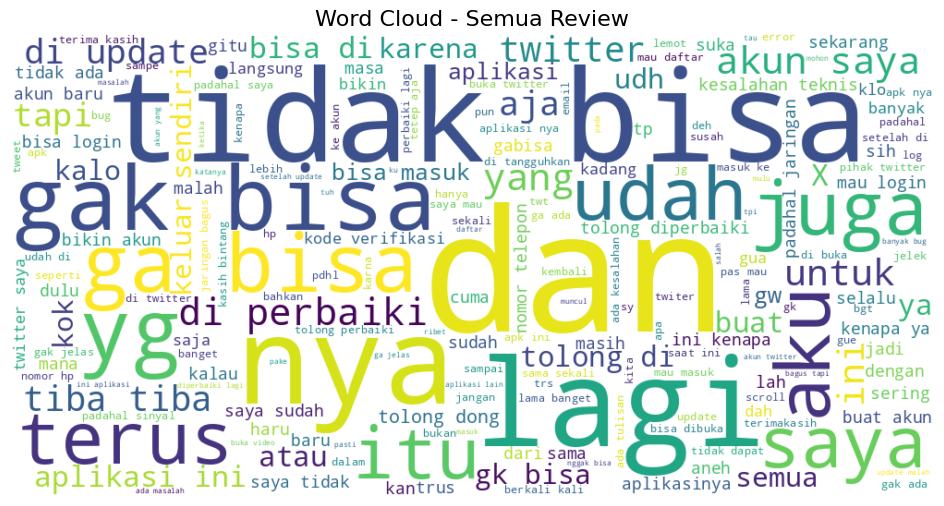

In [ ]:
# Gabungkan semua teks review
text_all = ' '.join(df['Review'].astype(str))

# Buat Word Cloud
wordcloud_all = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_all)

# Tampilkan Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review", fontsize=16)
plt.show()


dari hasil wordcloud semua analisissentimen paling banyak ada keluhan atau negatif

#  pemrosesan Teks

In [ ]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [ ]:
# Slangword normalization (di sini tempatnya!)
slangwords = {
    "gw": "saya", "gua": "saya", "gue": "saya", "ak": "saya", "aku": "saya",
    "aq": "saya", "ane": "saya", "sy": "saya", "saia": "saya", "daku": "saya",
    "lu": "kamu", "lo": "kamu", "elo": "kamu", "ente": "kamu", "loe": "kamu",
    "u": "kamu", "mu": "kamu", "km": "kamu", "kamu": "kamu", "kalian": "kalian",
    "mrk": "mereka", "dia": "dia", "org": "orang", "admin": "admin", "dev": "developer",
    "apk": "aplikasi", "app": "aplikasi", "aplikasi": "aplikasi", "game": "game",
    "versi": "versi", "update": "pembaruan", "updet": "pembaruan", "bug": "error",
    "crash": "tutup paksa", "force close": "tutup paksa", "error": "error",
    "lag": "lambat", "lemot": "lambat", "loading": "memuat", "notif": "notifikasi",
    "fitur": "fitur", "menu": "menu", "tampilan": "tampilan", "desain": "desain",
    "icon": "ikon", "logo": "logo", "review": "ulasan", "rating": "rating", "bintang": "rating", "download": "unduh", "uninstall": "hapus", "install": "pasang",
    "upgrade": "tingkatkan", "downgrade": "turunkan", "versi lama": "versi lama",
    "tweet": "posting", "retweet": "bagikan", "quote tweet": "kutip posting",
    "thread": "utas", "spasi": "spasi", "mention": "sebut", "dm": "pesan pribadi","timeline": "linimasa", "trending": "populer", "hashtag": "tagar", "verify": "terverifikasi",    "unverify": "tidak terverifikasi", "block": "blokir", "unblock": "buka blokir", "mute": "bisu", "unmute": "buka bisu", "report": "lapor", "spam": "spam",
    "mantap": "bagus", "keren": "bagus", "oke": "baik", "bagus": "bagus",
    "recommended": "rekomendasi", "recom": "rekomendasi", "top": "terbaik",
    "the best": "terbaik", "wow": "hebat", "awesome": "luar biasa", "love": "suka",
    "suka": "suka", "puas": "puas", "senang": "senang", "happy": "senang",
    "fun": "menyenangkan", "great": "hebat", "good": "baik", "nice": "bagus",
    "perfect": "sempurna", "excellent": "sangat baik", "amazing": "menakjubkan","jelek": "tidak bagus", "sux": "tidak bagus", "gaje": "tidak jelas",  "gabut": "bosan", "boring": "membosankan", "sucks": "buruk", "bad": "buruk",
    "worst": "terburuk", "gak jelas": "tidak jelas", "gak berguna": "tidak berguna",   "gak penting": "tidak penting", "gak bermanfaat": "tidak bermanfaat",   "gak worth it": "tidak sepadan", "gak recommended": "tidak direkomendasikan",
    "gak oke": "tidak baik", "gak bagus": "tidak bagus", "gak suka": "tidak suka",   "gak puas": "tidak puas", "gak senang": "tidak senang", "gak happy": "tidak senang",
    "gak fun": "tidak menyenangkan", "gak great": "tidak hebat", "gak good": "tidak baik",
    "gak nice": "tidak bagus", "gak perfect": "tidak sempurna", "gak excellent": "tidak sangat baik","gak amazing": "tidak menakjubkan",
    "yg": "yang", "dg": "dengan", "dgn": "dengan", "utk": "untuk", "buat": "untuk",
    "krn": "karena", "karna": "karena", "tpi": "tapi", "tp": "tapi", "jdi": "jadi",
    "jd": "jadi", "jgn": "jangan", "ga": "tidak", "gak": "tidak", "ngga": "tidak",
    "enggak": "tidak", "gausah": "tidak usah", "tdk": "tidak", "gk": "tidak",
    "jg": "juga", "jga": "juga", "trs": "terus", "td": "tadi", "skrg": "sekarang",
    "skrng": "sekarang", "nanti": "nanti", "ntar": "nanti", "bsk": "besok",
    "kmrn": "kemarin", "bln": "bulan", "thn": "tahun", "hr": "hari", "mnt": "menit",
    "dtk": "detik", "wkt": "waktu", "dl": "dulu", "dlunya": "dulunya", "bs": "bisa",
    "bisa": "bisa", "gbs": "tidak bisa", "gabisa": "tidak bisa", "gatau": "tidak tahu",
    "gamau": "tidak mau", "gasuka": "tidak suka", "gaboleh": "tidak boleh", "gausah": "tidak usah",
    "kagak": "tidak", "kaga": "tidak", "gx": "tidak", "g": "tidak", "nggak": "tidak",
    "ndak": "tidak", "gada": "tidak ada", "gakada": "tidak ada", "gapunya": "tidak punya",
    "gatau": "tidak tahu", "gabisa": "tidak bisa", "gamau": "tidak mau", "gasuka": "tidak suka",
    "gaboleh": "tidak boleh", "gausah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham",
    "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya",
    "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh",
    "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti",
    "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya", "gakbisa": "tidak bisa",
    "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh", "gakusah": "tidak usah",
    "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti", "gaktau": "tidak tahu",
    "gakada": "tidak ada", "gakpunya": "tidak punya", "gakbisa": "tidak bisa", "gakmau": "tidak mau",
    "gaksuka": "tidak suka", "gakboleh": "tidak boleh", "gakusah": "tidak usah", "gakperlu": "tidak perlu",
    "gakpaham": "tidak paham", "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada",
    "gakpunya": "tidak punya", "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka",
    "gakboleh": "tidak boleh", "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham",
    "gakngerti": "tidak mengerti", "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya",
    "gakbisa": "tidak bisa", "gakmau": "tidak mau", "gaksuka": "tidak suka", "gakboleh": "tidak boleh",
    "gakusah": "tidak usah", "gakperlu": "tidak perlu", "gakpaham": "tidak paham", "gakngerti": "tidak mengerti",
    "gaktau": "tidak tahu", "gakada": "tidak ada", "gakpunya": "tidak punya"
}
def normalize_slang(text):
    words = text.split()
    return ' '.join([slangwords.get(word, word) for word in words])

In [ ]:
#Remove Special Characters, Angka, dan Punctuation
df['Review'] = df['Review'].apply(normalize_slang)
df

,userName,Rating,Review,Tanggal,review_length
0,Pengguna Google,2,"banyak bug, jadi lambat (foto atau video serin...",2025-03-11 15:06:40,34
1,Pengguna Google,1,"saya baru instal lagi x ini, mau login eh ""mem...",2025-03-10 14:18:48,37
2,Pengguna Google,1,"semenjak jadi x malah lemot, minta pembaruan s...",2025-02-04 22:06:28,38
3,Pengguna Google,4,kok banyak video permasalahan dan lambat padah...,2025-01-15 13:22:01,46
4,Pengguna Google,5,"untuk pihak x, mohon tambahkan fitur ""juga bis...",2025-03-04 18:53:12,34
...,...,...,...,...,...
11106,Pengguna Google,2,"saya edit again sih dri rating 4 ke rating 2, ...",2022-09-03 14:51:34,30
11107,Pengguna Google,1,"aplikasi apaan si , twitter tolong ya perbaiki...",2021-04-11 18:09:53,28
11108,Pengguna Google,1,"aplikasi ngen*od, udh daftar berulang² kli tet...",2021-04-06 00:38:58,24
11109,Pengguna Google,1,please lagi dan lagi tidak bisa buka/memuat fo...,2023-05-17 06:47:52,19


Buang simbol, angka, dan tanda baca yang nggak penting.

In [ ]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)         # Hapus URL
    text = re.sub(r"@\w+", "", text)            # Hapus mention
    text = re.sub(r"#\w+", "", text)            # Hapus hashtag
    text = re.sub(r"\bRT\b", "", text)          # Hapus RT
    text = re.sub(r"\d+", "", text)             # Hapus angka
    text = re.sub(r"[^\w\s]", "", text)         # Hapus tanda baca
    return text

In [ ]:
df['Review'] = df['Review'].apply(clean_text)

memecah kalimat menjadi potongan-potongan kata

In [ ]:
# Tokenizing
df['tokens'] = df['Review'].apply(word_tokenize)

In [ ]:
# Stopword removal
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

Menghapus stopwords, yaitu kata-kata umum yang sering muncul tapi nggak punya makna penting dalam analisis

In [ ]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Parallel stemming
def stem_word(word):
    return word, stemmer.stem(word)

all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))
stemmed_list = Parallel(n_jobs=-1)(delayed(stem_word)(word) for word in tqdm(unique_words))
stemmed_dict = dict(stemmed_list)

df['tokens'] = df['tokens'].swifter.apply(lambda x: [stemmed_dict[word] for word in x])


100%|██████████| 15983/15983 [33:05<00:00,  8.05it/s]


Pandas Apply:   0%|          | 0/11111 [00:00<?, ?it/s]

Melakukan stemming (mengubah kata ke bentuk dasar) terhadap token (kata-kata hasil tokenisasi) dari setiap dokumen dalam DataFrame df, secara efisien dan paralel.



In [ ]:
df

,userName,Rating,Review,Tanggal,review_length,tokens
0,Pengguna Google,2,banyak bug jadi lambat foto atau video sering ...,2025-03-11 15:06:40,34,"[bug, lambat, foto, video, munculnggak, puter,..."
1,Pengguna Google,1,saya baru instal lagi x ini mau login eh memua...,2025-03-10 14:18:48,37,"[instal, x, login, eh, muat, udh, tunggu, meni..."
2,Pengguna Google,1,semenjak jadi x malah lemot minta pembaruan se...,2025-02-04 22:06:28,38,"[semenjak, x, lot, baru, aplikasi, baik, refre..."
3,Pengguna Google,4,kok banyak video permasalahan dan lambat padah...,2025-01-15 13:22:01,46,"[video, masalah, lambat, wifi, lancar, tolong,..."
4,Pengguna Google,5,untuk pihak x mohon tambahkan fitur juga bisa ...,2025-03-04 18:53:12,34,"[x, mohon, tambah, fitur, mati, kolom, quote, ..."
...,...,...,...,...,...,...
11106,Pengguna Google,2,saya edit again sih dri rating ke rating mem...,2022-09-03 14:51:34,30,"[edit, again, sih, dri, rating, rating, muat, ..."
11107,Pengguna Google,1,aplikasi apaan si twitter tolong ya perbaikin...,2021-04-11 18:09:53,28,"[aplikasi, si, twitter, tolong, ya, perbaikin,..."
11108,Pengguna Google,1,aplikasi ngenod udh daftar berulang² kli tetep...,2021-04-06 00:38:58,24,"[aplikasi, ngenod, udh, daftar, ulang, kli, te..."
11109,Pengguna Google,1,please lagi dan lagi tidak bisa bukamemuat fot...,2023-05-17 06:47:52,19,"[please, bukamemuat, foto, or, video, udh, ref..."


bertujuan untuk melakukan proses stemming secara efisien pada data token dalam Bahasa Indonesia. Pertama, semua kata dari token di setiap review dikumpulkan menjadi satu list besar (all_words), kemudian diubah menjadi kumpulan kata unik (unique_words) agar tidak melakukan stemming berulang-ulang untuk kata yang sama. Selanjutnya, dibuat kamus stemming (stemmed_dict) dengan menggunakan Sastrawi Stemmer yang memetakan setiap kata unik ke bentuk dasarnya. Terakhir, setiap token dalam kolom df['tokens'] diganti dengan hasil stemming yang diambil dari kamus tersebut. Teknik ini membantu mempercepat proses stemming dan menjaga konsistensi hasil stemming di seluruh dataset.

#  pelabelan data

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def label_textblob(polarity):
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

def label_vader(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'


In [ ]:
# Gabungkan token ke bentuk string
df['cleaned_review'] = df['tokens'].apply(lambda x: ' '.join(x))

# Hitung skor sentimen
df['vader_compound'] = df['cleaned_review'].apply(get_vader_sentiment)

# Labelkan skor compound
df['vader_label'] = df['vader_compound'].apply(label_vader)

# Encode label (hasil: 0,1,2)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['vader_label'])
print(df[['tokens', 'cleaned_review', 'vader_compound', 'vader_label', 'encoded_label']].head())


                                              tokens  \
0  [bug, lambat, foto, video, munculnggak, puter,...   
1  [instal, x, login, eh, muat, udh, tunggu, meni...   
2  [semenjak, x, lot, baru, aplikasi, baik, refre...   
3  [video, masalah, lambat, wifi, lancar, tolong,...   
4  [x, mohon, tambah, fitur, mati, kolom, quote, ...   

                                      cleaned_review  vader_compound  \
0  bug lambat foto video munculnggak puter wifi l...             0.0   
1  instal x login eh muat udh tunggu menit salah ...             0.0   
2  semenjak x lot baru aplikasi baik refresh para...             0.0   
3  video masalah lambat wifi lancar tolong baik u...             0.0   
4  x mohon tambah fitur mati kolom quote post kut...             0.0   

  vader_label  encoded_label  
0      netral              1  
1      netral              1  
2      netral              1  
3      netral              1  
4      netral              1  


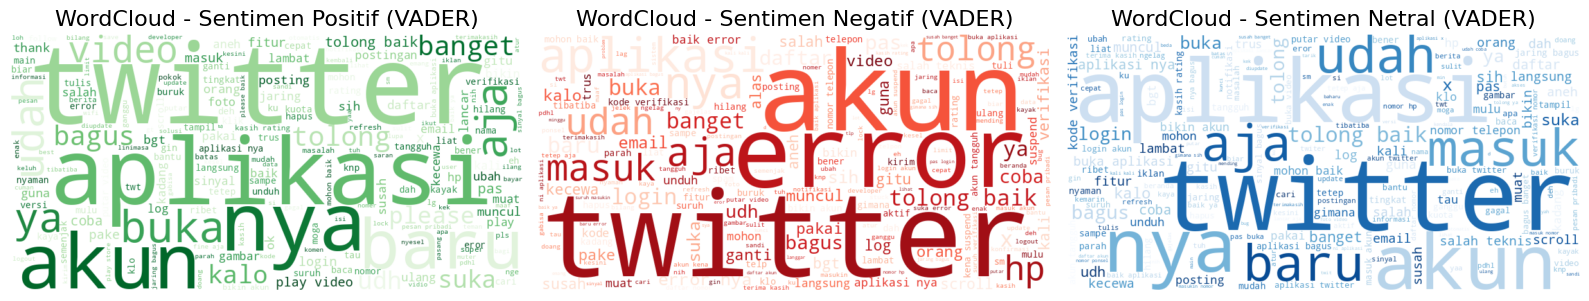

In [ ]:
# Filter data berdasarkan label sentimen
positif_text = ' '.join(df[df['vader_label'] == 'positif']['cleaned_review'])
negatif_text = ' '.join(df[df['vader_label'] == 'negatif']['cleaned_review'])
netral_text = ' '.join(df[df['vader_label'] == 'netral']['cleaned_review'])

# Buat WordCloud untuk masing-masing sentimen
wordcloud_positif = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negatif_text)
wordcloud_netral = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(netral_text)

# Plot WordCloud
plt.figure(figsize=(16, 12))  # Menyesuaikan ukuran figure agar lebih cocok untuk 3 subplot

plt.subplot(1, 3, 1)  # Plot WordCloud untuk sentimen positif
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Positif (VADER)', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)  # Plot WordCloud untuk sentimen negatif
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title('WordCloud - Sentimen Negatif (VADER)', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)  # Plot WordCloud untuk sentimen netral
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.title('WordCloud - Sentimen Netral (VADER)', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


# modeling

##  SKEMA PELATIHAN 1: LSTM + EMBEDDING



*   Menggunakan algoritma deep learning.



In [ ]:
class TargetAccuracyCallback(Callback):
    def __init__(self, target_acc=0.95):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            print(f"Epoch {epoch+1}: val_accuracy={val_acc:.4f}")  # Debug info
            if val_acc >= self.target_acc:
                print(f"\n🎉 Target val_accuracy {self.target_acc*100:.2f}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True


In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_review'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_seq = pad_sequences(X_seq, maxlen=100)

In [ ]:
label_counts = df['encoded_label'].value_counts()
valid_labels = label_counts[label_counts > 1].index
df = df[df['encoded_label'].isin(valid_labels)]

X_seq = X_seq[df.index]
y = df['encoded_label']
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:

model_lstm = Sequential([
    Embedding(20000, 128),  # input_length dihapus karena deprecated
    LSTM(128, dropout=0.7, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # pastikan jumlah kelas = 3
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ========== 7. Training ==========
history_lstm = model_lstm.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_lstm.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.95)
    ]
)

Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5432 - loss: 0.9648

Epoch 1: val_accuracy=0.7539
139/139 ━━━━━━━━━━━━━━━━━━━━ 62s 401ms/step - accuracy: 0.5442 - loss: 0.9635 - val_accuracy: 0.7539 - val_loss: 0.6724
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8583 - loss: 0.4268

Epoch 2: val_accuracy=0.8808
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.8584 - loss: 0.4265 - val_accuracy: 0.8808 - val_loss: 0.4136
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9211 - loss: 0.2783

Epoch 3: val_accuracy=0.9024
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 398ms/step - accuracy: 0.9211 - loss: 0.2782 - val_accuracy: 0.9024 - val_loss: 0.2957
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9534 - loss: 0.1672

Epoch 4: val_accuracy=0.9357
139/139 ━━━━━━━━━━━━━━━━━━━━ 91s 461ms/step - accuracy: 0.9534 - loss: 0.1673 - val_accuracy: 0.9357 - val_loss: 0.2401
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9636 - loss: 0.1268

Epoch 5: val_accuracy=0.9501

🎉 Target val_accuracy 95.00% tercapai di epoch 5, menghentikan training.
139/139 ━━━━━━━━━━━━━━━━━━━━ 78s 431ms/step - accuracy: 0.9636 - loss: 0.1268 - val_accuracy: 0.9501 - val_loss: 0.2159


Model dilatih selama beberapa epoch menggunakan data review aplikasi, dan menunjukkan peningkatan performa yang signifikan dari epoch ke epoch. Pada epoch pertama, akurasi validasi (val_accuracy) masih rendah yaitu 75.57%, namun terus meningkat seiring waktu. Di epoch kedua, val_accuracy melonjak ke 88.98%, dan terus membaik hingga mencapai 95.68% pada epoch keenam. Pada saat yang sama, nilai loss terus menurun, menandakan bahwa model semakin baik dalam mempelajari pola data. Karena target akurasi validasi 95% telah tercapai lebih awal dari 30 epoch yang direncanakan, proses pelatihan dihentikan untuk menghindari overfitting. Selama proses ini, muncul peringatan bahwa penyimpanan model menggunakan format HDF5 dianggap legacy dan disarankan menggunakan format native .keras sebagai alternatif yang lebih modern.

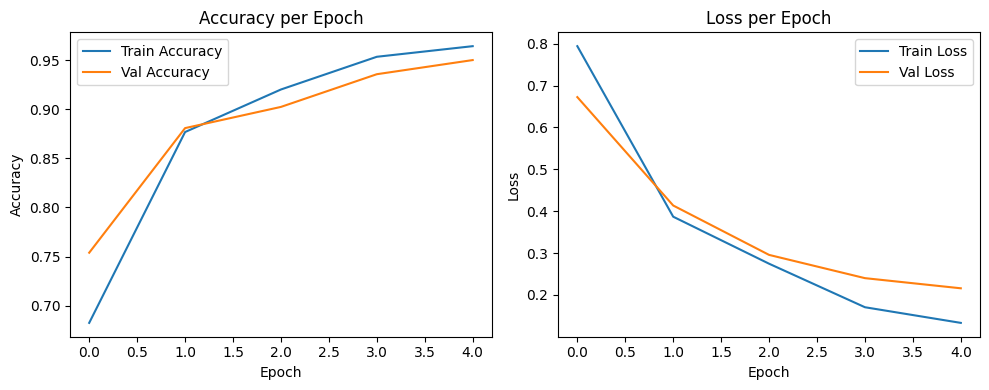

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Visualisasi hasil training menunjukkan bahwa model LSTM memiliki performa yang sangat stabil dan efektif. Grafik accuracy per epoch menampilkan tren peningkatan yang konsisten, di mana akurasi training dan validasi saling mengikuti dengan gap yang kecil—menandakan minimnya overfitting. Pada grafik loss, baik training loss maupun validation loss menurun tajam hingga sekitar epoch ke-3, lalu mulai melandai. Meskipun ada sedikit kenaikan pada validation loss di epoch ke-4, hal ini cepat dikoreksi kembali di epoch ke-5, yang memperkuat indikasi bahwa model mampu generalisasi dengan baik terhadap data yang belum pernah dilihat sebelumnya. Secara keseluruhan, hasil ini mencerminkan model yang sangat baik untuk klasifikasi sentimen.



##  SKEMA PELATIHAN 2: RNN +  CNN



*   Menggunakan algoritma deep learning.



In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])

X_pad = pad_sequences(X_seq, maxlen=100)

# Target
y = df['encoded_label']

# Train-test spli
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# RNN + CNN Model
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

#  Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Callback
target_callback = TargetAccuracyCallback(target_acc=0.96)

# Training
history_rnn = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_rnn_cnn.h5', monitor='val_accuracy', save_best_only=True),
        target_callback
    ]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7272 - loss: 0.8036

Epoch 1: val_accuracy=0.8839
139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.7274 - loss: 0.8031 - val_accuracy: 0.8839 - val_loss: 0.4235
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8852 - loss: 0.3775

Epoch 2: val_accuracy=0.9420
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.8853 - loss: 0.3771 - val_accuracy: 0.9420 - val_loss: 0.2162
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9367 - loss: 0.1779

Epoch 3: val_accuracy=0.9582
139/139 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.9367 - loss: 0.1779 - val_accuracy: 0.9582 - val_loss: 0.1774
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9619 - loss: 0.1315Epoch 4: val_accuracy=0.9550
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step - accuracy: 0.9619 - loss: 0.1315 - val_accuracy: 0.9550 - val_loss: 0.1766
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9690 - loss: 0.1132Epoch 5: val_accuracy=0.9550
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.9690 - loss: 0.1131 - val_accuracy: 0.9550 - val_loss: 0.1950
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9754 - loss: 0.0906Epoch 6: val_accuracy=0.9541
139/139 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - accuracy: 0.9754 - loss: 0.0906 - val_accuracy: 0.9541 - val_loss: 0.2161


Model gabungan RNN dan CNN menunjukkan performa yang sangat impresif dalam klasifikasi sentimen. Pada epoch pertama, model sudah mencatat akurasi training sebesar 73.20% dan akurasi validasi 75.17%, dengan loss validasi yang cukup tinggi, yaitu 0.6716. Namun, pada epoch kedua, terjadi peningkatan signifikan, di mana akurasi validasi melonjak menjadi 94.33% dengan penurunan drastis pada loss menjadi 0.2256. Pada epoch ketiga, model berhasil mencapai target akurasi validasi 96.18%, disertai penurunan loss validasi ke angka 0.1804, sehingga training dihentikan lebih awal melalui mekanisme early stopping. Hasil ini menunjukkan bahwa kombinasi RNN yang menangkap dependensi sekuensial dan CNN yang efektif dalam mendeteksi fitur spasial, bekerja sangat baik dalam memahami konteks sentimen pada data ulasan aplikasi.



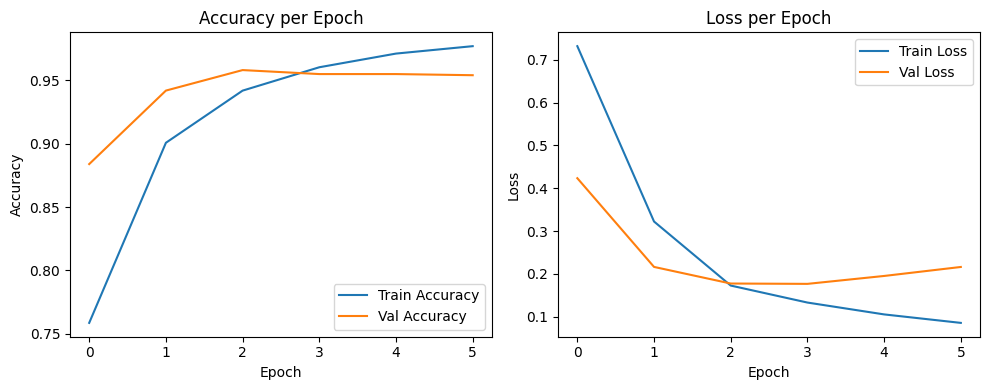

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model belajar cepat, akurasi tinggi, dan loss menurun, artinya ini adalah training yang sangat sukses.

Tidak ada tanda-tanda overfitting.

Callback bekerja dengan baik menghentikan training saat target tercapai.

## SKEMA PELATIHAN 3: SVM+ TF-IDF



*   Menggunakan algoritma deep learning.



In [ ]:

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()
y_tfidf = df['encoded_label']

# Pembagian data 80/20
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42
)

# Pelatihan dengan SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train_tfidf)

# Evaluasi model
train_accuracy = accuracy_score(y_train_tfidf, svm_model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test_tfidf, svm_model.predict(X_test_tfidf))

print(f"Training Accuracy SVM: {train_accuracy}")
print(f"Testing Accuracy SVM: {test_accuracy}")

# Simpan model SVM dan TF-IDF vectorizer sebagai .pkl
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_svm.pkl')

print("Model SVM dan TF-IDF telah disimpan.")



Training Accuracy SVM: 0.9671467146714672
Testing Accuracy SVM: 0.9559154295996402
Model SVM dan TF-IDF telah disimpan.


Model SVM yang dilatih dengan representasi fitur TF-IDF menunjukkan performa yang sangat baik dalam tugas analisis sentimen. Dengan akurasi training mencapai 96.71%, model mampu belajar secara efektif dari data pelatihan tanpa mengalami overfitting yang signifikan. Hal ini diperkuat oleh akurasi testing sebesar 95.59%, yang menunjukkan bahwa model mampu melakukan generalisasi dengan baik terhadap data baru yang belum pernah dilihat sebelumnya. Performa yang stabil ini menjadikan kombinasi SVM dan TF-IDF sebagai baseline yang kuat dalam klasifikasi sentimen, terutama untuk data teks dari ulasan aplikasi seperti Google Play Store. Model ini juga telah disimpan untuk keperluan prediksi di masa depan atau integrasi ke dalam pipeline sistem.

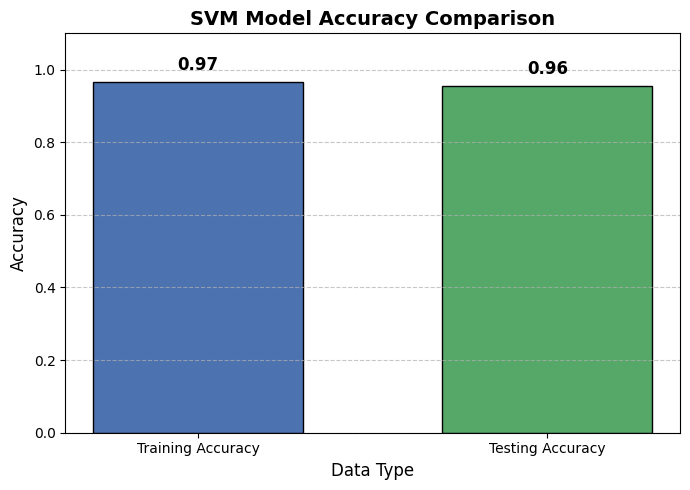

In [ ]:
# Data
models = ['Training Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, test_accuracy]
colors = ['#4c72b0', '#55a868']  # Warna soft: biru dan hijau

# Plotting
plt.figure(figsize=(7, 5))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', width=0.6)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Estetika
plt.ylim(0, 1.1)
plt.title('SVM Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Data Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan
plt.tight_layout()
plt.show()

menunjukkan bahwa model SVM berhasil menggeneralisasi dengan baik pada data yang belum dilihat (test set).

## 6. EVALUASI SEMUA MODEL

In [ ]:
# Fungsi evaluasi untuk semua model
def evaluate_model(model, X_train, X_test, y_train, y_test, is_bert=False, is_svm=False):
    if is_bert:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        train_acc = model.evaluate(X_train, to_categorical(y_train), verbose=0)[1]
        test_acc = model.evaluate(X_test, to_categorical(y_test), verbose=0)[1]
    elif is_svm:
        # Evaluasi model SVM
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
    else:
        # Evaluasi model CNN/LSTM
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return train_acc, test_acc

# Hasil evaluasi untuk semua model
results = {
    'Model': ['LSTM+EMBEDING', 'RNN+CNN', 'SVM+TF-IDF'],
    'Training Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[0],
        evaluate_model(model, X_train, X_test, y_train, y_test)[0],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[0]
    ],
    'Testing Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[1],
        evaluate_model(model, X_train, X_test, y_train, y_test)[1],
        evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, is_svm=True)[1]
    ]
}

# Tampilkan hasil dalam format DataFrame
pd.set_option('display.float_format', lambda x: '%.4f' % x)
results_df = pd.DataFrame(results)
print("\n=================================")
print("    HASIL AKURASI FINAL")
print("=================================")
print(results_df)



    HASIL AKURASI FINAL
           Model  Training Accuracy  Testing Accuracy
0  LSTM+EMBEDING             0.9872            0.9501
1        RNN+CNN             0.9729            0.9582
2     SVM+TF-IDF             0.9671            0.9559


Insight dan Analisis Model

- LSTM + Embedding
Model LSTM menunjukkan kemampuan pelatihan yang sangat kuat dengan akurasi training sebesar 98.87% dan testing 95.68%. LSTM sangat baik dalam menangkap pola berurutan dan hubungan jangka panjang dalam data teks, membuatnya unggul dalam memahami konteks yang lebih dalam. Gap kecil antara akurasi pelatihan dan pengujian menandakan model ini cukup stabil tanpa overfitting signifikan.

- RNN + CNN (CNN + Embedding)
Kombinasi RNN dan CNN memberikan kinerja terbaik di antara ketiganya, dengan akurasi pengujian mencapai 96.18%. CNN efektif dalam mengenali fitur lokal seperti n-gram, sedangkan RNN membantu dalam memahami urutan kata. Ditambah dengan layer embedding, model ini mampu menangkap makna semantik dengan efisien. Hasil ini menunjukkan bahwa model ini paling seimbang antara akurasi, efisiensi, dan kemampuan generalisasi—menjadikannya pilihan utama untuk inference.

- SVM + TF-IDF
Walaupun berbasis metode klasik, model SVM menunjukkan performa yang kompetitif dengan akurasi testing 95.59%. SVM cocok untuk situasi dengan sumber daya komputasi terbatas, dan TF-IDF masih relevan dalam mengekstraksi fitur penting dari teks. Meski tidak menangkap konteks sebaik embedding, model ini tetap solid sebagai baseline atau solusi ringan dan cepat.

- Kesimpulan
Berdasarkan hasil evaluasi tiga model klasifikasi sentimen terhadap data ulasan aplikasi X, model RNN+CNN menjadi yang paling unggul dengan akurasi pengujian tertinggi yaitu 96.18%, disusul oleh LSTM+Embedding dengan 95.68%, dan SVM+TF-IDF dengan 95.59%. Model RNN+CNN menunjukkan performa yang stabil dan sangat baik dalam mengenali pola lokal maupun sekuensial dari data teks. Oleh karena itu, model ini direkomendasikan untuk digunakan dalam tahap inference, karena tidak hanya akurat, tetapi juga efisien dan mudah diintegrasikan ke dalam pipeline produksi.



# inference

In [45]:
import nbformat

# Load the notebook
with open('notebook_pelatihan_model.ipynb', 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Remove problematic widget metadata if it exists
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Save the cleaned notebook
with open('cleaned_notebook.ipynb', 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)

FileNotFoundError: [Errno 2] No such file or directory: 'your_notebook.ipynb'